In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tifffile as tif
import cv2
from PIL import Image
import os
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt 

In [2]:
import face_recognition

In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
image_dir = 'patches/images/'
mask_dir = 'patches/mask/'

In [6]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [7]:
images = os.listdir(image_dir)
for i, image_name in enumerate(images):
    if(image_name.split('.')[1] == 'tiff'):
        #print(image_name)
        image =  cv2.imread(image_dir+image_name,0)
        #print(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE,SIZE))
        image_dataset.append(np.array(image))

In [ ]:
#image_dataset

In [8]:
masks = os.listdir(mask_dir)
for i ,mask_name in enumerate(masks):
    if(mask_name.split('.')[1]=='tiff'):
        mask = cv2.imread(mask_dir+mask_name,0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE,SIZE))
        mask_dataset.append(np.array(mask))

In [ ]:
#mask_dataset

In [9]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset),axis = 1),3)

In [10]:
mask_dataset = np.expand_dims(np.array(mask_dataset),3)/255

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size=0.10,random_state=42)

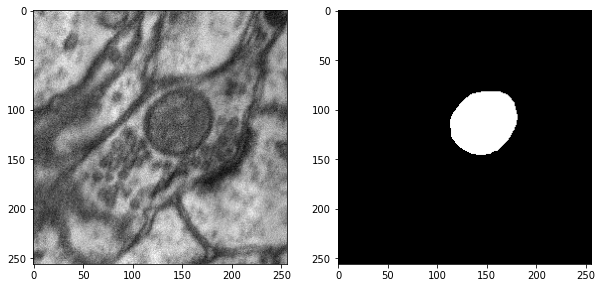

In [15]:
import random
import numpy as np
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)),cmap='gray')
plt.show()

In [16]:
X_train.shape

(1782, 256, 256, 1)

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


In [18]:
from Simple_Unet import simple_unet_model

In [19]:
def get_model():
    return simple_unet_model(IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)

In [20]:
model = get_model()

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [23]:
model.compile(optimizer = 'adam',loss ='binary_crossentropy',metrics = ['accuracy'])

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size = 16,epochs = 10,shuffle=False)

Epoch 1/10
112/112 [==============================] - 30s 198ms/step - loss: 0.2865 - accuracy: 0.9365 - val_loss: 0.2336 - val_accuracy: 0.9452
Epoch 2/10
112/112 [==============================] - 20s 175ms/step - loss: 0.1410 - accuracy: 0.9435 - val_loss: 0.1560 - val_accuracy: 0.9453
Epoch 3/10
112/112 [==============================] - 19s 173ms/step - loss: 0.0733 - accuracy: 0.9717 - val_loss: 0.1192 - val_accuracy: 0.9494
Epoch 4/10
112/112 [==============================] - 20s 175ms/step - loss: 0.0428 - accuracy: 0.9834 - val_loss: 0.1497 - val_accuracy: 0.9373
Epoch 5/10
112/112 [==============================] - 19s 174ms/step - loss: 0.0303 - accuracy: 0.9882 - val_loss: 0.1530 - val_accuracy: 0.9468
Epoch 6/10
112/112 [==============================] - 19s 173ms/step - loss: 0.0222 - accuracy: 0.9912 - val_loss: 0.0425 - val_accuracy: 0.9841
Epoch 7/10
112/112 [==============================] - 19s 173ms/step - loss: 0.0204 - accuracy: 0.9919 - val_loss: 0.0566 - val_ac

In [25]:
acc = model.evaluate(X_test,y_test)

7/7 [==============================] - 3s 83ms/step - loss: 0.0210 - accuracy: 0.9922


In [26]:
y_pred = model.predict(X_test)
y_pred_threshold = y_pred>0.5
#y_pred

In [ ]:
#y_pred_threshold

In [27]:
intersection = np.logical_and(y_test,y_pred_threshold)
union = np.logical_or(y_test,y_pred_threshold)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.8686772750459556


In [ ]:
#model.save('Diceloss_10 epochs.h5')

In [39]:
test_img_nos = random.randint(0,len(X_test))
test_img = X_test[test_img_nos]
ground_truth = y_test[test_img_nos]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm,0)
prediction = (model.predict(test_img_input)[0,:,:,0]>0.5).astype(np.uint8)

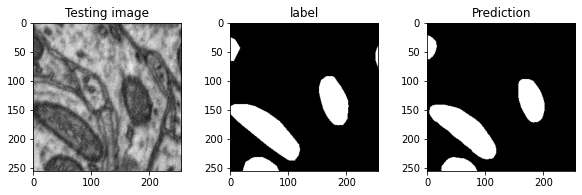

In [40]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('label')
plt.imshow(ground_truth[:,:,0],cmap ='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction,cmap='gray')
plt.show()